In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [24]:
method_rename_dict = {
        'velocyto': "Velocyto",
        'scvelo_dyn': "scVelo (dyn)",
        'scvelo_stc': "scVelo (stc)",
        'veloae': "VeloAE",
        'dynamo_m1': "Dynamo (m1)",
        'unitvelo_ind': "UniTVelo (ind)",
        'unitvelo_uni': "UniTVelo (uni)",
        'velovae_std': "VeloVAE (std)",
        'velovae_fullvb': "VeloVAE (Full VB)",
        'deepvelo': "DeepVelo",
        'celldancer': "cellDancer",
        'pyrovelocity_m1': "Pyro-Velocity (m1)",
        'pyrovelocity_m2': "Pyro-Velocity (m2)",
        'kvelo': "κ-velo",
        'velovi': "veloVI",
        'cell2fate': "cell2fate",
        'sdevelo': "SDEvelo",
        'svelvetvae': "SvelvetVAE",
        'latentvelo_std': "LatentVelo (std)",
        'tivelo_std': "TIVelo (std)",
        'tivelo_simple': "TIVelo (simple)",
        'multivelo': "MultiVelo",
        'velvetvae': "VelvetVAE",
        'graphvelo_std': "GraphVelo (std)"}

In [25]:
method_colors = {
    'velocyto': "#6587AB",
    'scvelo_dyn': "#76B7B2",
    'scvelo_stc': "#92CB8A",
    'veloae': "#F6A24F",
    'dynamo_m1': "#FF9DA7",
    'unitvelo_ind': "#9C755F",
    'unitvelo_uni': "#DC6F71",
    'velovae_std': "#C6A11B",
    'velovae_fullvb': "#4F5CD5",
    'deepvelo': "#B07AA1",
    'celldancer': "#2E91E5",
    'pyrovelocity_m1': "#1EB754",
    'pyrovelocity_m2': "#FFBE7A",
    'kvelo': "#A05195",
    'velovi': "#B5BD61",
    'cell2fate': "#AD2513",
    'sdevelo': "#1F3E80",
    'svelvetvae': "#F6D55C",
    'latentvelo_std': "#6ACCBC",
    'tivelo_std': "#694D34",
    'tivelo_simple': "#F39B7F",
    'graphvelo_std': "#0AC7DC"
}

In [26]:
datasets = ["data04"]

In [27]:
all_scores_direction = []
all_scores_time = []

for dataset in datasets:
    df = pd.read_csv(Path(dataset)  / "cbdir_stability_df.csv")

    df = df[df["Method"] != "svelvetvae_with_smooth"]
    df = df[df["Method"] != "sctour_mse"]
    df = df[df["Method"] != "sctour_zinb"]
    df = df[df["Method"] != "sctour_nb"]

    df["stability_score"] = df.iloc[:,1]
    df = df[["Method", "stability_score"]]
    df["dataset"] = dataset
    all_scores_direction.append(df)

concat_df_direction = pd.concat(all_scores_direction, ignore_index=True)

for dataset in datasets:
    df = pd.read_csv(Path(dataset)  / "icvcoh_stability_df.csv")
    df = df[df["Method"] != "svelvetvae_with_smooth"]

    df["stability_score"] = df.iloc[:,1]
    df = df[["Method", "stability_score"]]
    df["dataset"] = dataset
    all_scores_time.append(df)

concat_df_time = pd.concat(all_scores_time, ignore_index=True)

In [28]:

overall_mean_direction = (
    concat_df_direction.groupby("Method")["stability_score"]
    .mean()
    .reset_index()
    .rename(columns={"stability_score": "S_CBDir"})
)
# overall_mean_direction["Method"] = overall_mean_direction["Method"].map(method_rename_dict)

overall_mean_time = (
    concat_df_time.groupby("Method")["stability_score"]
    .mean()
    .reset_index()
    .rename(columns={"stability_score": "S_ICVCoh"})
)

# overall_mean_time["Method"] = overall_mean_time["Method"].map(method_rename_dict)

concat_overall_mean = pd.merge(overall_mean_direction, overall_mean_time, on="Method")
concat_overall_mean

,Method,S_CBDir,S_ICVCoh
0,cell2fate,0.201911,0.775427
1,celldancer,0.583478,0.601366
2,deepvelo,0.483520,0.843100
3,dynamo_m1,0.611625,0.789010
4,graphvelo_std,0.692991,0.802252
5,kvelo,0.659092,0.761572
6,latentvelo_std,0.400512,0.882208
7,pyrovelocity_m1,0.356939,0.901508
8,pyrovelocity_m2,0.746101,0.867476
9,scvelo_dyn,0.685473,0.849862


In [29]:
from scipy.stats import spearmanr
rho, pval = spearmanr(concat_overall_mean['S_CBDir'], concat_overall_mean['S_ICVCoh'])
print(rho)
print(pval)

-0.023150762281197064
0.9185490835113286


# Scatter plot

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

def plot_overall_scatter(
    concat_overall_mean: pd.DataFrame,
    method_colors: dict,
    x_col: str = "mean SSD",
    y_col: str = "mean SST",
    figsize=(5, 4),
    point_size: int = 200,
    edge_color: str = "black",
    annotate: bool = False,
    show_legend: bool = True,
    xlim: tuple = None,
    ylim: tuple = None,
):
    """
    Scatter plot of overall mean metrics (mean SSD vs mean SST) for each method.

    Parameters:
    ----------
    annotate: bool
        If True, displays method names on the scatter plot.
    show_legend: bool
        If True, displays the legend on the right side of the plot.
    """
    concat_overall_mean["color"] = concat_overall_mean["Method"].map(method_colors)

    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        concat_overall_mean[x_col],
        concat_overall_mean[y_col],
        c=concat_overall_mean["color"],
        s=point_size,
        edgecolors=None,
        linewidths=0,
        alpha=1
    )

    # === Option to annotate method names ===
    if annotate:
        for _, row in concat_overall_mean.iterrows():
            ax.text(
                row[x_col],
                row[y_col],
                row["Method"],
                fontsize=9,
                ha="center",
                va="center",
                fontweight="medium",
                color="black",
                alpha=1
            )

    # === Option to add legend on the right side ===
    if show_legend:
        legend_elements = [
            Line2D([0], [0], marker='o', color='w',
                   label=method, markerfacecolor=color, markersize=8,
                   markeredgecolor=None, markeredgewidth=0)
            for method, color in method_colors.items()
            if method in concat_overall_mean["Method"].values
        ]
        ax.legend(
            handles=legend_elements,
            title="Methods",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            frameon=False,
            fontsize=9,
            title_fontsize=10,
            ncol=1
        )

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.tick_params(axis='both', length=5)

    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_color("black")

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        # label.set_fontname('Arial')
        # label.set_fontweight('bold')
        label.set_fontsize(12)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    return fig, ax

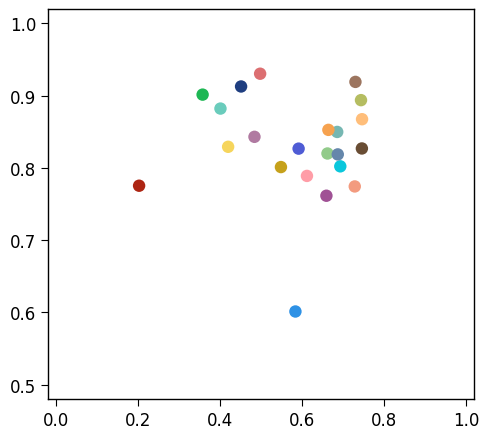

In [31]:
fig, ax = plot_overall_scatter(concat_overall_mean,
                     method_colors,
                     x_col='S_CBDir',
                     y_col='S_ICVCoh',
                     figsize=(5, 4.5),
                     point_size=80,
                     annotate=False,
                     show_legend=False,
                     xlim=(-0.02, 1.02),
                     ylim=(0.48, 1.02))
plt.tight_layout()
plt.savefig("quantification_scatter.svg", format="svg", bbox_inches="tight", dpi=300)
plt.show()

# Streamline plot

In [32]:
umap_colors = [
    "#d0af4c",
    "#d8a373",  # deep blue
    "#fddea5",
    "#7a4171",  # deep red
    "#897858",# rich green
    "#2a83a2",  # rose
    "#6c848d",  # medium gray
    "#84b9cb",
]

In [33]:
from pathlib import Path
import os
import scanpy as sc
import numpy as np
dataset = Path("data04")
methods_for_pan = ["unitvelo_ind"]
methods_for_qn = ["alevin","kallisto_bustools","dropest","starsolo","velocyto"]

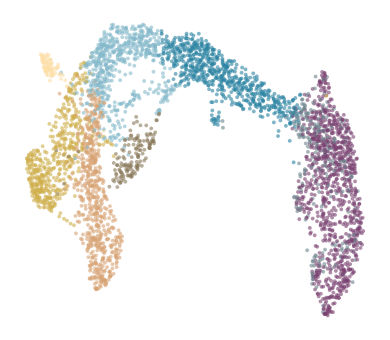

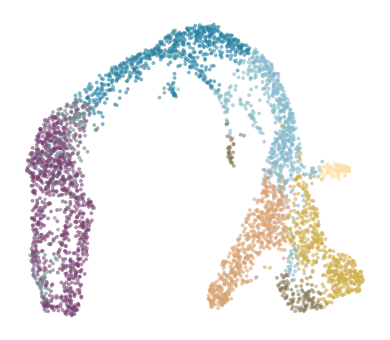

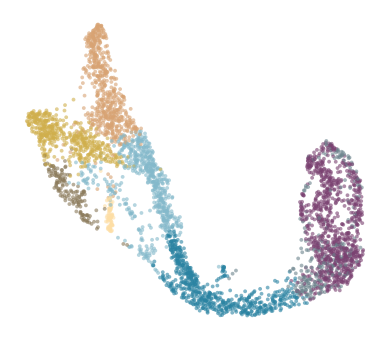

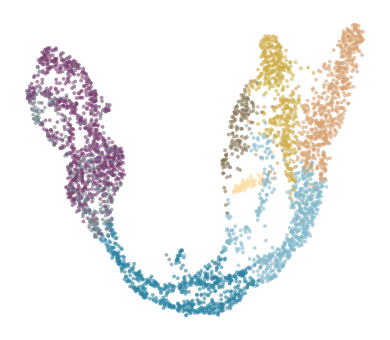

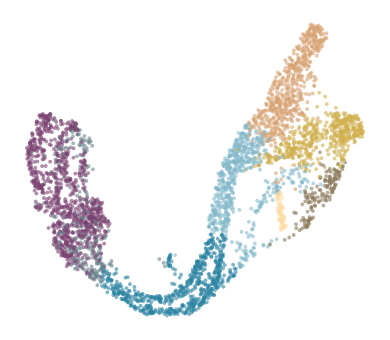

In [34]:
cluster_key = 'clusters'
for index in range(5):
    adata = sc.read_h5ad(dataset / f"adata_preprocessed_{index}.h5ad")

    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]

    fig, ax = plt.subplots(figsize=(4, 3.5))
    sc.pl.umap(
        adata,
        color=cluster_key,
        palette=color_map,
        alpha = 0.6,
        title='',
        legend_loc='none',
        ax=ax,
        size=30,
        show=False,
    )

    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{dataset}_embedding_{methods_for_qn[index]}.png", bbox_inches='tight', dpi=300)
    plt.show()

computing velocity graph (using 20/24 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_umap', embedded velocity vectors (adata.obsm)


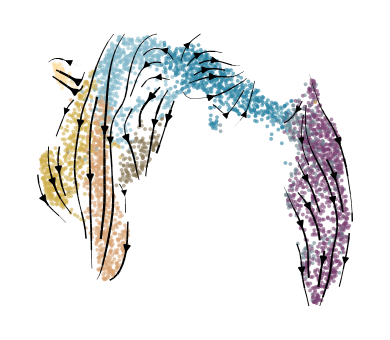

computing velocity graph (using 20/24 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_umap', embedded velocity vectors (adata.obsm)


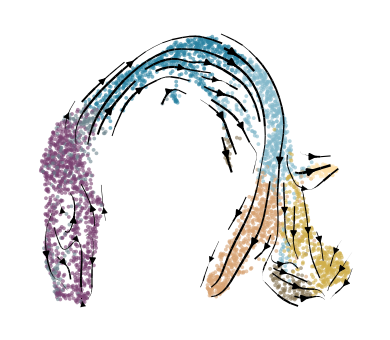

computing velocity graph (using 20/24 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_umap', embedded velocity vectors (adata.obsm)


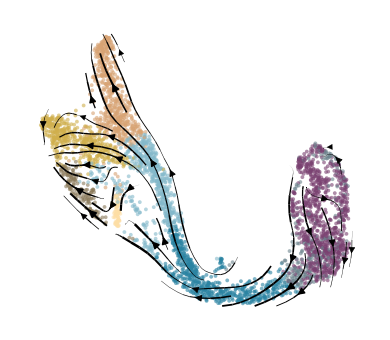

computing velocity graph (using 20/24 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_umap', embedded velocity vectors (adata.obsm)


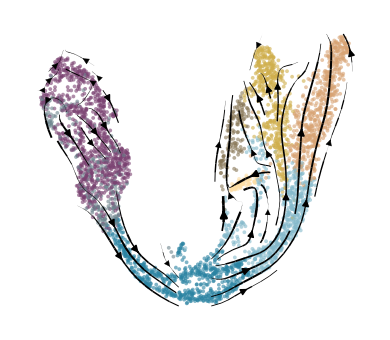

computing velocity graph (using 20/24 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_umap', embedded velocity vectors (adata.obsm)


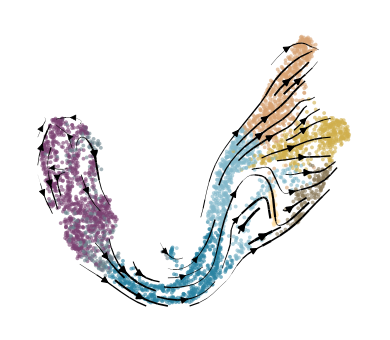

In [35]:
from scipy.sparse import issparse
import scvelo as scv
cluster_key = 'clusters'
for method in methods_for_pan:
    for index in range(5):

        vkey = f"{method}_velocity"

        adata = sc.read_h5ad( dataset / f"adata_run_{method}_{index}.h5ad")

        if issparse(adata.layers[vkey]):
            adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
        adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])
        sqrt_transform = False
        if method in ["unitvelo_ind", "unitvelo_uni"]:
            sqrt_transform = True
        
        scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=sqrt_transform,n_jobs=20)

        adata.uns[f'{cluster_key}_colors'] = umap_colors
        adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
        cluster_order = adata.obs[cluster_key].cat.categories
        cell_types = adata.obs[cluster_key].values
        unique_types = np.unique(cell_types)
        color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
        adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
        kwargs = dict(
            frameon=True, add_margin=.1,density=1,linewidth=1,alpha=0.6,
            size=30,
        )

        # atac size = 120
        fig, ax = plt.subplots(figsize=(4, 3.5))
        scv.pl.velocity_embedding_stream(
            adata,
            color=cluster_key,
            vkey=vkey,
            basis='umap',
            title='',
            # legend_loc = 'upper right',
            legend_loc='none',
            ax=ax,
            **kwargs,
            show=False
        )
        ax.set_title('')
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(f"{method}_{methods_for_qn[index]}_stream.png", bbox_inches='tight', dpi=300)
        plt.show()